In [1]:
import requests
import json 
from bs4 import BeautifulSoup as bs
from tqdm import tqdm

urls = json.load(open("pandas_apis.json"))
data_frame_url = urls["df"]

In [2]:
print(data_frame_url)

https://pandas.pydata.org/docs/reference/frame.html


In [3]:
import os 

if not os.path.exists("api_details"):
    os.mkdir("api_details")

In [4]:
import re
def get_details_about_apis(which_type_of_url, _url):
    invalid_count = 0
    page = requests.get(_url)
    soup = bs(page.content, 'html.parser')
    all_about_apis = []
    codes = soup.find_all("code", {"class": "xref py py-obj docutils literal notranslate"})
    for code in codes:
        api_name = code.find("span").text
        if "." in api_name:
            api_name = api_name[api_name.index(".") + 1:]
        documentation = list(code.parent.parent.parent.parent.children)[2].find("p").text
        try:
            category = code.parent.parent.parent.parent.parent.parent.parent.find("h2").text[:-1]
        except:
            category = which_type_of_url
        if len(api_name.strip()) == 0 or len(documentation.strip()) == 0 or len(category.strip()) == 0:
            invalid_count += 1
            continue
        all_about_apis.append({
            "api": re.sub(",", " ", str(api_name.encode("ascii", errors="ignore").decode())),
            "doc": re.sub(",", " ", str(documentation.encode("ascii", errors="ignore").decode())),
            "category": re.sub(",", " ", str(category.encode("ascii", errors="ignore").decode()))
        })
    print(invalid_count)
    return all_about_apis
    
all_about_dataframe_apis = get_details_about_apis("dataframe", data_frame_url)
fp = open("api_details/all_about_dataframe_apis.json", "w")
json.dump(all_about_dataframe_apis, fp, indent=4)
fp.close()

1


In [5]:
all_apis_with_all_details = []
for which in urls.keys():
    all_apis_with_all_details.extend(get_details_about_apis(which, urls[which]))

2
1
3
1
31
12
2


In [6]:
import csv
 
data_file = open('api_details/data_frame_api_details.csv', 'w')
keys = all_about_dataframe_apis[0].keys()
data_file.write("api,category,doc\n")
count = 0
for data in all_about_dataframe_apis:
    data_file.write(data["api"] + "," + data["category"] + "," + data["doc"] + "\n")
 
data_file.close()

In [7]:
import csv
 
data_file = open('api_details/pandas_api_details.csv', 'w')
keys = all_apis_with_all_details[0].keys()
data_file.write("api,category,doc\n")
count = 0
for data in all_apis_with_all_details:
    data_file.write(data["api"] + "," + data["category"] + "," + data["doc"] + "\n")
 
data_file.close()

In [8]:
import nltk
taken_answer_dir = "25_K_Examples"
all_taken_answers = []
for part in range(1, 4):
    taken_answers = json.load(
        open(
            os.path.join(
                taken_answer_dir, 
                f"part-{part}-output/taken_answers_with_all_details.json"
            )
        )
    )
    for answer in taken_answers:
        all_taken_answers.append(answer["formatted_input"])

print(len(all_taken_answers))

print(json.dumps(all_about_dataframe_apis[10:12], indent=4))


def token_in_api_data(token):
    for api_idx, api_obj in enumerate(all_about_dataframe_apis):
        api = str(api_obj["api"]).strip()
        if token.strip() == api:
            return api_idx
    return None
        
taken_examples = []
taken_apis = set()
for exidx, example in enumerate(all_taken_answers):
    code = example["answer"]["code"]
    example["answer"]["api_seq"] = set()
    for c in code:
        tokens = nltk.wordpunct_tokenize(c)
        for t in tokens:
            api_idx = token_in_api_data(t)
            if api_idx is not None:
                example["answer"]["api_seq"].add(str(all_about_dataframe_apis[api_idx]["api"]))
                taken_apis.add(api_idx)
    if len(example["answer"]["api_seq"]) > 0:
        taken_examples.append(example)

all_taken_answers = taken_examples
print(len(all_taken_answers))

all_about_dataframe_apis = [all_about_dataframe_apis[idx] for idx in taken_apis]
print(len(all_about_dataframe_apis))
print(json.dumps(
    [" ".join(sorted(list(example["answer"]["api_seq"]))) for example in all_taken_answers[:50]], indent=4))
    

659
[
    {
        "api": "shape",
        "doc": "Return a tuple representing the dimensionality of the DataFrame.",
        "category": "Attributes and underlying data"
    },
    {
        "api": "memory_usage",
        "doc": "Return the memory usage of each column in bytes.",
        "category": "Attributes and underlying data"
    }
]
619
142
[
    "any astype cumsum div groupby mask ne shift sub",
    "attrs div",
    "eq where",
    "astype bool columns cumsum loc lt mask select_dtypes shift",
    "DataFrame columns isin loc",
    "DataFrame insert",
    "add all astype drop dropna groupby index mean reset_index rolling",
    "groupby",
    "agg apply values",
    "columns drop melt",
    "iloc",
    "apply groupby",
    "any clip groupby index mean reindex shape stack std",
    "DataFrame to_period",
    "set_index squeeze unstack update",
    "astype columns drop duplicated groupby loc max where",
    "columns drop dropna melt reset_index sort_values",
    "bool",
    "apply

In [9]:
import numpy as np 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

def remove_punc(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in symbols:
        data = np.char.replace(data, i, ' ')
    return str(data)

def remove_single_char(data):
    new_text = ""
    words = data.split()
    for w in words:
        if len(w) > 1:
           new_text = new_text + " " + w
    return new_text

def remove_stopword(data):
    stop_words = stopwords.words("english")
    words = data.split()
    new_text = ""
    for word in words:
        if word not in stop_words:
            new_text = new_text + " " + word
    return new_text

def stem(data):
    ps = PorterStemmer()
    words = data.split()
    new_text = ""
    for w in words:
        new_text += (" " + ps.stem(w))
    return new_text

def lematize(data):
    ps = WordNetLemmatizer()
    words = data.split()
    new_text = ""
    for w in words:
        new_text += (" " + ps.lemmatize(w))
    return new_text

def dataframe(data):
    words = data.split()
    new_text = ""
    for word in words:
        if word == "df" or word == "dataframe":
            word = "data frame"
        new_text += (" " + word)
    return new_text

def preprocess(data):
    words = word_tokenize(data)
    data = " ".join(words)
    data = np.char.lower(data)
    data = remove_punc(data)
    data = str(np.char.replace(data, "'", ""))
    data = remove_single_char(data)
    data = remove_stopword(data)
    data = stem(data)
    data = lematize(data)
    data = dataframe(data)
    data = remove_punc(data)
    return data


# Only Title

In [10]:
sentences = []
apis = []
for point in all_about_dataframe_apis:
    sentences.append(preprocess(point["doc"]))
    apis.append(point["api"])

for answer in all_taken_answers:
    ques = answer["question"]
    title = ques["title"]
    sentences.append(preprocess(title))
    pass

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences)
print(X.shape)

documentation_features = X[:len(all_about_dataframe_apis), :]
example_features = X[len(all_about_dataframe_apis):, :]
print(documentation_features.shape, example_features.shape)

from sklearn.metrics.pairwise import cosine_similarity
similarity_results = cosine_similarity(documentation_features, example_features)
print(similarity_results.shape)

(761, 707)
(142, 707) (619, 707)
(142, 619)


## From example perspective 
### Total points = len(examples)

In [12]:
!pip install matplotlib

  Using cached matplotlib-3.3.4-cp36-cp36m-manylinux1_x86_64.whl (11.5 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.1-cp36-cp36m-manylinux1_x86_64.whl (1.1 MB)


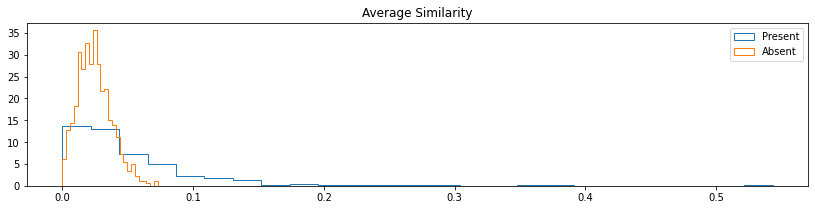

TTest stat :  Ttest_indResult(statistic=11.965012007504335, pvalue=3.928890964310584e-30)
Present Mean   : 0.0499
Absent  Mean   : 0.0245
Present Median : 0.0357
Absent  Median : 0.0235


In [13]:
overlap_p_ques = []
overlap_a_ques = []
for exidx, example in enumerate(all_taken_answers):
    code = example["answer"]["code"]
    present_scores, absent_scores = [], []
    for api_idx, api in enumerate(apis):
        api = str(api)  
        found = False
        for c in code:
            if api in c:
                found = True
                break
        if found:
            present_scores.append(similarity_results[api_idx, exidx])
        else:
            absent_scores.append(similarity_results[api_idx, exidx])
    overlap_p_ques.append(
        np.mean(present_scores) if len(present_scores) > 0 else 0.0
    )
    overlap_a_ques.append(
        np.mean(absent_scores) if len(absent_scores) > 0 else 0.0,
    )

import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.hist(overlap_p_ques, label="Present", bins=25, histtype=u'step', density=True)
plt.hist(overlap_a_ques, label="Absent", bins=25, histtype=u'step', density=True)
plt.title("Average Similarity")
plt.legend()
plt.show()
from scipy import stats
ttest_result = stats.ttest_ind(overlap_p_ques, overlap_a_ques, equal_var=False)
print("TTest stat : ", ttest_result)
import numpy as np
print("Present Mean   : %.4lf" % np.mean(overlap_p_ques))
print("Absent  Mean   : %.4lf" % np.mean(overlap_a_ques))
print("Present Median : %.4lf" % np.median(overlap_p_ques))
print("Absent  Median : %.4lf" % np.median(overlap_a_ques))

## From API perspective
### Total points = len(apis)

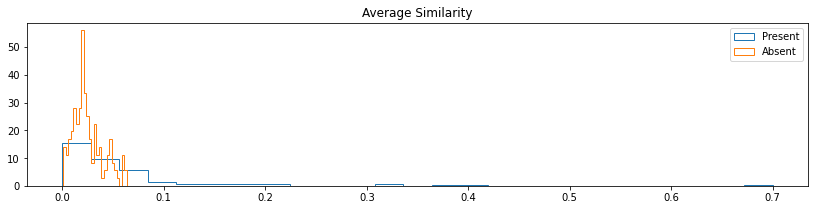

TTest stat :  Ttest_indResult(statistic=4.226880581905975, pvalue=4.1112679398158726e-05)
Present Mean   : 0.0561
Absent  Mean   : 0.0249
Present Median : 0.0335
Absent  Median : 0.0214


In [14]:
overlap_p_api = []
overlap_a_api = []
for api_idx, api in enumerate(apis):
    api = str(api)  
    present_scores, absent_scores = [], []
    for exidx, example in enumerate(all_taken_answers):
        code = example["answer"]["code"]
        found = False
        for c in code:
            if api in c:
                found = True
                break
        if found:
            present_scores.append(similarity_results[api_idx, exidx])
        else:
            absent_scores.append(similarity_results[api_idx, exidx])
    overlap_p_api.append(
        np.mean(present_scores) if len(present_scores) > 0 else 0.0
    )
    overlap_a_api.append(
        np.mean(absent_scores) if len(absent_scores) > 0 else 0.0,
    )

import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.hist(overlap_p_api, label="Present", bins=25, histtype=u'step', density=True)
plt.hist(overlap_a_api, label="Absent", bins=25, histtype=u'step', density=True)
plt.title("Average Similarity")
plt.legend()
plt.show()

from scipy import stats
ttest_result = stats.ttest_ind(overlap_p_api, overlap_a_api, equal_var=False)
print("TTest stat : ", ttest_result)
import numpy as np
print("Present Mean   : %.4lf" % np.mean(overlap_p_api))
print("Absent  Mean   : %.4lf" % np.mean(overlap_a_api))
print("Present Median : %.4lf" % np.median(overlap_p_api))
print("Absent  Median : %.4lf" % np.median(overlap_a_api))

## From Both Perspective
### Total points = len(examples) * len(apis)

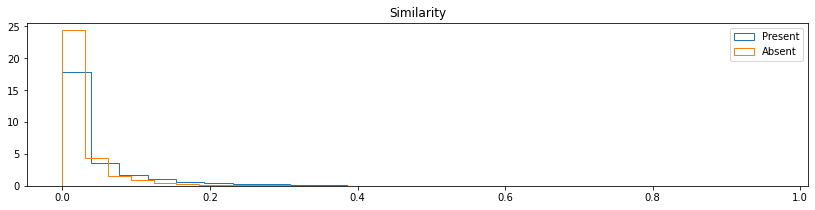

TTest stat :  Ttest_indResult(statistic=15.380415398638172, pvalue=7.185285292939048e-52)
Present Mean   : 0.0439
Absent  Mean   : 0.0246
Present Median : 0.0175
Absent  Median : 0.0000


In [15]:
overlap_p_both = []
overlap_a_both = []
for api_idx, api in enumerate(apis):
    api = str(api)  
    for exidx, example in enumerate(all_taken_answers):
        code = example["answer"]["code"]
        found = False
        for c in code:
            if api in c:
                found = True
                break
        if found:
            overlap_p_both.append(similarity_results[api_idx, exidx])
        else:
            overlap_a_both.append(similarity_results[api_idx, exidx])

import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.hist(overlap_p_both, label="Present", bins=25, histtype=u'step', density=True)
plt.hist(overlap_a_both, label="Absent", bins=25, histtype=u'step', density=True)
plt.title("Similarity")
plt.legend()
plt.show()


from scipy import stats
ttest_result = stats.ttest_ind(overlap_p_both, overlap_a_both, equal_var=False)
print("TTest stat : ", ttest_result)
import numpy as np
print("Present Mean   : %.4lf" % np.mean(overlap_p_both))
print("Absent  Mean   : %.4lf" % np.mean(overlap_a_both))
print("Present Median : %.4lf" % np.median(overlap_p_both))
print("Absent  Median : %.4lf" % np.median(overlap_a_both))

# Title + Desc

In [16]:
sentences = []
apis = []
for point in all_about_dataframe_apis:
    sentences.append(preprocess(point["doc"]))
    apis.append(point["api"])

for answer in all_taken_answers:
    ques = answer["question"]
    title = ques["title"]
    desc = ques["ques_desc"]
    sentences.append(preprocess(title + " " + desc))
    pass

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences)
print(X.shape)

documentation_features = X[:len(all_about_dataframe_apis), :]
example_features = X[len(all_about_dataframe_apis):, :]
print(documentation_features.shape, example_features.shape)

from sklearn.metrics.pairwise import cosine_similarity
similarity_results = cosine_similarity(documentation_features, example_features)
print(similarity_results.shape)


(761, 2208)
(142, 2208) (619, 2208)
(142, 619)


## From Example perspective

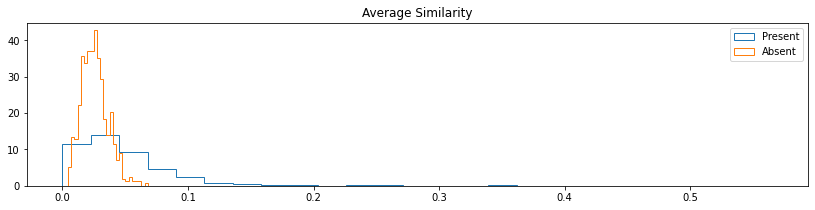

TTest stat :  Ttest_indResult(statistic=12.053953197466535, pvalue=1.829277151622194e-30)
Present Mean   : 0.0491
Absent  Mean   : 0.0258
Present Median : 0.0389
Absent  Median : 0.0249


In [17]:
overlap_p_ques = []
overlap_a_ques = []
for exidx, example in enumerate(all_taken_answers):
    code = example["answer"]["code"]
    present_scores, absent_scores = [], []
    for api_idx, api in enumerate(apis):
        api = str(api)  
        found = False
        for c in code:
            if api in c:
                found = True
                break
        if found:
            present_scores.append(similarity_results[api_idx, exidx])
        else:
            absent_scores.append(similarity_results[api_idx, exidx])
    overlap_p_ques.append(
        np.mean(present_scores) if len(present_scores) > 0 else 0.0
    )
    overlap_a_ques.append(
        np.mean(absent_scores) if len(absent_scores) > 0 else 0.0,
    )

import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.hist(overlap_p_ques, label="Present", bins=25, histtype=u'step', density=True)
plt.hist(overlap_a_ques, label="Absent", bins=25, histtype=u'step', density=True)
plt.title("Average Similarity")
plt.legend()
plt.show()

from scipy import stats
ttest_result = stats.ttest_ind(overlap_p_ques, overlap_a_ques, equal_var=False)
print("TTest stat : ", ttest_result)
import numpy as np
print("Present Mean   : %.4lf" % np.mean(overlap_p_ques))
print("Absent  Mean   : %.4lf" % np.mean(overlap_a_ques))
print("Present Median : %.4lf" % np.median(overlap_p_ques))
print("Absent  Median : %.4lf" % np.median(overlap_a_ques))

## From API perspective

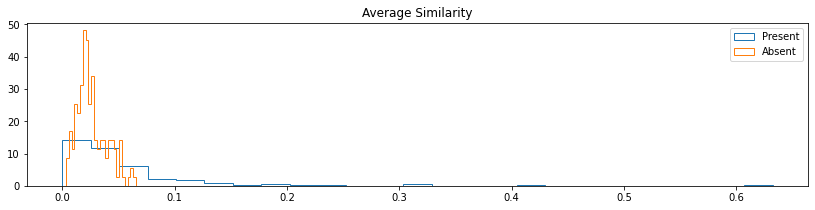

TTest stat :  Ttest_indResult(statistic=4.82378157833358, pvalue=3.4368818922924526e-06)
Present Mean   : 0.0580
Absent  Mean   : 0.0261
Present Median : 0.0398
Absent  Median : 0.0226


In [18]:
overlap_p_api = []
overlap_a_api = []
for api_idx, api in enumerate(apis):
    api = str(api)  
    present_scores, absent_scores = [], []
    for exidx, example in enumerate(all_taken_answers):
        code = example["answer"]["code"]
        found = False
        for c in code:
            if api in c:
                found = True
                break
        if found:
            present_scores.append(similarity_results[api_idx, exidx])
        else:
            absent_scores.append(similarity_results[api_idx, exidx])
    overlap_p_api.append(
        np.mean(present_scores) if len(present_scores) > 0 else 0.0
    )
    overlap_a_api.append(
        np.mean(absent_scores) if len(absent_scores) > 0 else 0.0,
    )

import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.hist(overlap_p_api, label="Present", bins=25, histtype=u'step', density=True)
plt.hist(overlap_a_api, label="Absent", bins=25, histtype=u'step', density=True)
plt.title("Average Similarity")
plt.legend()
plt.show()

from scipy import stats
ttest_result = stats.ttest_ind(overlap_p_api, overlap_a_api, equal_var=False)
print("TTest stat : ", ttest_result)
import numpy as np
print("Present Mean   : %.4lf" % np.mean(overlap_p_api))
print("Absent  Mean   : %.4lf" % np.mean(overlap_a_api))
print("Present Median : %.4lf" % np.median(overlap_p_api))
print("Absent  Median : %.4lf" % np.median(overlap_a_api))

## Both API and Example

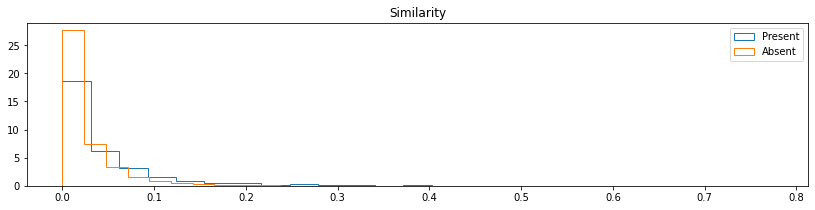

TTest stat :  Ttest_indResult(statistic=17.90609690413063, pvalue=5.721271092675435e-69)
Present Mean   : 0.0444
Absent  Mean   : 0.0258
Present Median : 0.0233
Absent  Median : 0.0127


In [19]:
overlap_p_both = []
overlap_a_both = []
for api_idx, api in enumerate(apis):
    api = str(api)  
    for exidx, example in enumerate(all_taken_answers):
        code = example["answer"]["code"]
        found = False
        for c in code:
            if api in c:
                found = True
                break
        if found:
            overlap_p_both.append(similarity_results[api_idx, exidx])
        else:
            overlap_a_both.append(similarity_results[api_idx, exidx])

import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.hist(overlap_p_both, label="Present", bins=25, histtype=u'step', density=True)
plt.hist(overlap_a_both, label="Absent", bins=25, histtype=u'step', density=True)
plt.title("Similarity")
plt.legend()
plt.show()
from scipy import stats
ttest_result = stats.ttest_ind(overlap_p_both, overlap_a_both, equal_var=False)
print("TTest stat : ", ttest_result)
import numpy as np
print("Present Mean   : %.4lf" % np.mean(overlap_p_both))
print("Absent  Mean   : %.4lf" % np.mean(overlap_a_both))
print("Present Median : %.4lf" % np.median(overlap_p_both))
print("Absent  Median : %.4lf" % np.median(overlap_a_both))

# Motivating Example

In [20]:
tile = "Pandas index column"
desc = """
I am trying to concat three files into one xlsx file. I'm able to concat but the index column is not getting removed. My Dataframe after using concat function is having index column of all three xlsx file from 0 to 3000 for three times. How should I approach to resolve the issue?
"""

processed_sent = preprocess(title + " " + desc)
print(processed_sent)

 python datafram get nan column row tri concat three file one xlsx file abl concat index column get remov datafram use concat function index column three xlsx file 3000 three time approach resolv issu


In [21]:
features = vectorizer.transform([processed_sent])
print(features.shape)

_ex_similarity_results = cosine_similarity(documentation_features, features)[:, 0].tolist()
api_with_scores = [(a, s) for a, s in zip(apis, _ex_similarity_results)]
sorted_apis = sorted(api_with_scores, key=lambda x: x[1])[::-1]
print(sorted_apis[:10])

(1, 2208)
[('set_index', 0.13666423627047228), ('index', 0.13079018802171838), ('droplevel', 0.12429880403649632), ('to_csv', 0.11807878209164217), ('transpose', 0.11306946255839406), ('rename_axis', 0.09749191140902971), ('keys', 0.09724875987534112), ('drop_duplicates', 0.09306897991355599), ('filter', 0.09097423737944232), ('iterrows', 0.08861150178191882)]


# Putting documentation analysis to work
Given the a question in the stackoverflow post, we willl analyze the similarity between the post and the api documentations. For every post, we will take the top `k` API matches and evaluate how good it is. 

In [22]:
sentences = []
apis = []

for point in all_about_dataframe_apis:
    sentences.append(preprocess(point["doc"]))
    apis.append(point["api"])

for answer in all_taken_answers:
    ques = answer["question"]
    title = ques["title"]
    desc = ques["ques_desc"]
    sentences.append(preprocess(title + " " + desc))
    pass

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences)
print(X.shape)

documentation_features = X[:len(all_about_dataframe_apis), :]
example_features = X[len(all_about_dataframe_apis):, :]
print(documentation_features.shape, example_features.shape)

from sklearn.metrics.pairwise import cosine_similarity
similarity_results = cosine_similarity(example_features, documentation_features)
print(similarity_results.shape)

(761, 2208)
(142, 2208) (619, 2208)
(619, 142)


In [23]:
for exid, example in enumerate(all_taken_answers):
    pred_similaroty = [(a, s) for a, s in zip(apis, similarity_results[exid, :].tolist())]
    sorted_apis = sorted(pred_similaroty, key=lambda x: x[1])[::-1]
    example["expected"] = example["answer"]["api_seq"]
    example["predicted"] = sorted_apis
    
print(all_taken_answers[0].keys())
    

dict_keys(['qid', 'link', 'question', 'io', 'answer', 'expected', 'predicted'])


In [26]:
def analyze_performance(top_k):
    result = []
    percentage = []
    count = []
    for example in all_taken_answers:
        match_found = 0
        prediction_apis = [x[0] for x in example["predicted"][:top_k]]
        expected = set(example['expected'])
        num_apis = len(expected)
        for api in expected:
            if api in prediction_apis:
                match_found += 1
        result.append({
            'example': example,
            'num_apis': num_apis,
            'match_found': match_found,
            'percentage': match_found/float(num_apis)
        })
        count.append(match_found)
        percentage.append(match_found/float(num_apis) * 100)
    return result, percentage, count


def show_performance(k, max_apis=8):
    top_k_res, top_k_per, top_k_count = analyze_performance(k)

    count_to_percentage = {}
    for res in top_k_res:
        if res['num_apis'] not in count_to_percentage:
            count_to_percentage[res['num_apis']] = []
        count_to_percentage[res['num_apis']].append(res)
        pass
    print("|" + ("=" * 55) + "|")
    print("|" + (" " * 25) + f"Top %2d" %k + (" " * 24) + "|")
    print("|" + ("-" * 55) + "|")
    print("| #APIs\t| #Examples\t| Full\t| Half\t| 1/3\t| 1/4\t|")
    print("|" + ("-" * 55) + "|")
    full, half, one_third, one_fourth, total_nums = 0, 0, 0, 0, 0
    for num_actual_api in sorted(count_to_percentage.keys()):
        if num_actual_api > max_apis:
            break
        results = count_to_percentage[num_actual_api]
        total_full_correct = sum([1 if r['percentage'] > 0.999 else 0 for r in results])
        full += total_full_correct
        total_half_correct = sum([1 if r['percentage'] >= 0.499 else 0 for r in results])
        half += total_half_correct
        total_one_third_correct = sum([1 if r['percentage'] >= 0.33 else 0 for r in results])
        one_third += total_one_third_correct
        total_one_fourth_correct = sum([1 if r['percentage'] >= 0.2499 else 0 for r in results])
        one_fourth += total_one_fourth_correct
        total_nums += len(results)
        print(
            "| %d\t| %d\t\t| %d\t| %d\t| %d\t| %d\t|" % (
                num_actual_api, 
                len(results),
                total_full_correct, 
                total_half_correct, 
                total_one_third_correct, 
                total_one_fourth_correct, 
            )
        )
        pass
    print("|" + ("=" * 55) + "|")
    print(
            "| %s\t| %d\t\t| %d\t| %d\t| %d\t| %d\t|" % (
                "total", 
                total_nums,
                full, 
                half, 
                one_third, 
                one_fourth, 
            )
        )
    print("|" + ("=" * 55) + "|")
    return top_k_res, count_to_percentage
    pass


# Now the result in terms of performance

```
example = {
    "title_desc": "hello world"
    "target": {"foo", "bar"}, 
}

docs = {
    "foo": "jello",
    "bar": "apple", 
    "tar": "spicy",
}

query -> set(positve samples), set(negative)
        pos -> {"jello", "apple"}, 
        neg -> {"spicy"}
```

In [27]:
show_performance(1);

|=======================================================|
|                         Top  1                        |
|-------------------------------------------------------|
| #APIs	| #Examples	| Full	| Half	| 1/3	| 1/4	|
|-------------------------------------------------------|
| 1	| 111		| 7	| 7	| 7	| 7	|
| 2	| 111		| 0	| 11	| 11	| 11	|
| 3	| 110		| 0	| 0	| 26	| 26	|
| 4	| 81		| 0	| 0	| 0	| 14	|
| 5	| 66		| 0	| 0	| 0	| 0	|
| 6	| 52		| 0	| 0	| 0	| 0	|
| 7	| 19		| 0	| 0	| 0	| 0	|
| 8	| 14		| 0	| 0	| 0	| 0	|
|=======================================================|
| total	| 564		| 7	| 18	| 44	| 58	|
|=======================================================|


In [28]:
show_performance(2);

|=======================================================|
|                         Top  2                        |
|-------------------------------------------------------|
| #APIs	| #Examples	| Full	| Half	| 1/3	| 1/4	|
|-------------------------------------------------------|
| 1	| 111		| 10	| 10	| 10	| 10	|
| 2	| 111		| 0	| 20	| 20	| 20	|
| 3	| 110		| 0	| 2	| 35	| 35	|
| 4	| 81		| 0	| 2	| 2	| 19	|
| 5	| 66		| 0	| 0	| 2	| 2	|
| 6	| 52		| 0	| 0	| 2	| 2	|
| 7	| 19		| 0	| 0	| 0	| 0	|
| 8	| 14		| 0	| 0	| 0	| 0	|
|=======================================================|
| total	| 564		| 10	| 34	| 71	| 88	|
|=======================================================|


In [29]:
show_performance(5);

|=======================================================|
|                         Top  5                        |
|-------------------------------------------------------|
| #APIs	| #Examples	| Full	| Half	| 1/3	| 1/4	|
|-------------------------------------------------------|
| 1	| 111		| 17	| 17	| 17	| 17	|
| 2	| 111		| 2	| 35	| 35	| 35	|
| 3	| 110		| 0	| 9	| 50	| 50	|
| 4	| 81		| 0	| 4	| 4	| 33	|
| 5	| 66		| 0	| 2	| 11	| 11	|
| 6	| 52		| 0	| 1	| 5	| 5	|
| 7	| 19		| 0	| 0	| 1	| 3	|
| 8	| 14		| 0	| 0	| 0	| 0	|
|=======================================================|
| total	| 564		| 19	| 68	| 123	| 154	|
|=======================================================|


In [30]:
_, count_to_p = show_performance(10);

|=======================================================|
|                         Top 10                        |
|-------------------------------------------------------|
| #APIs	| #Examples	| Full	| Half	| 1/3	| 1/4	|
|-------------------------------------------------------|
| 1	| 111		| 25	| 25	| 25	| 25	|
| 2	| 111		| 6	| 43	| 43	| 43	|
| 3	| 110		| 1	| 14	| 64	| 64	|
| 4	| 81		| 1	| 11	| 11	| 54	|
| 5	| 66		| 0	| 7	| 26	| 26	|
| 6	| 52		| 0	| 3	| 14	| 14	|
| 7	| 19		| 0	| 1	| 3	| 6	|
| 8	| 14		| 0	| 0	| 0	| 4	|
|=======================================================|
| total	| 564		| 33	| 104	| 186	| 236	|
|=======================================================|
